In [51]:
import pandas as pd
from person_matching_functions import *
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing

In [2]:
direct_feature_weights = {
    'First Name Match Score': 0.20,
    'Last Name Match Score': 0.35,
    'Gender Match Score': 0.30,
    'Age Match Score': 0.15
}

mother_feature_weights = {
    'Mother First Name Match Score': 0.20,
    'Mother Last Name Match Score': 0.35,
    'Gender Match Score': 0.30,
    'Age Match Score': 0.15,
}

father_feature_weights = {
    'Father First Name Match Score': 0.20,
    'Father Last Name Match Score': 0.35,
    'Gender Match Score': 0.30,
    'Age Match Score': 0.15,
}

In [3]:
df = pd.read_pickle('matches/matched_records_baptisms_all.pkl')

In [4]:
df['First Name Match Score'] = np.where(df['First Name Match Classifier'] <= 2, 1, 0)
df['Last Name Match Score'] = np.where(df['Last Name Match Classifier'] <= 2, 1, 0)
df['Mother First Name Match Score'] = np.where(df['Mother First Name Match Classifier'] <= 2, 1, 0)
df['Mother Last Name Match Score'] = np.where(df['Mother Last Name Match Classifier'] <= 2, 1, 0)
df['Father First Name Match Score'] = np.where(df['Father First Name Match Classifier'] <= 2, 1, 0)
df['Father Last Name Match Score'] = np.where(df['Father Last Name Match Classifier'] <= 2, 1, 0)

df['Age Match Score'] = np.where(df['Age Match Range'] <= 3, 1, 0)

df['Gender Match Score'] = (df['Census Gender'] == df['Baptisms Gender']).astype(int)

df.drop(['First Name Match Classifier', 'Last Name Match Classifier', 'Mother First Name Match Classifier',
         'Mother Last Name Match Classifier', 'Father First Name Match Classifier', 'Father Last Name Match Classifier',
         'Age Match Range'], inplace=True, axis=1)

In [5]:
male_df = df[df['Census Gender'] == 'm'].copy()
female_df = df[df['Census Gender'] == 'f'].copy()

In [6]:
for score_name, weight in direct_feature_weights.items():
    df[score_name + ' Weighted'] = df[score_name] * weight

In [7]:
direct_weighted_columns = [score + ' Weighted' for score in direct_feature_weights.keys()]
df['Direct Match Score'] = df[direct_weighted_columns].sum(axis=1)

In [8]:
for score_name, weight in mother_feature_weights.items():
    female_df[score_name + ' Weighted'] = female_df[score_name] * weight

In [9]:
direct_weighted_columns = [score + ' Weighted' for score in mother_feature_weights.keys()]
female_df['Parent Match Score'] = female_df[direct_weighted_columns].sum(axis=1)

In [10]:
for score_name, weight in father_feature_weights.items():
    male_df[score_name + ' Weighted'] = male_df[score_name] * weight

In [11]:
direct_weighted_columns = [score + ' Weighted' for score in father_feature_weights.keys()]
male_df['Parent Match Score'] = male_df[direct_weighted_columns].sum(axis=1)

In [12]:
# parent_df = pd.concat([female_df, male_df])

In [13]:
direct_threshold = 0.8
parent_threshold = 0.8

In [14]:
df['Is Direct Match'] = df['Direct Match Score'] >= direct_threshold
female_df['Is Parent Match'] = female_df['Parent Match Score'] >= parent_threshold
male_df['Is Parent Match'] = male_df['Parent Match Score'] >= parent_threshold

In [15]:
is_direct_match = df['Direct Match Score'] >= direct_threshold

In [16]:
direct_df = df[is_direct_match == True]

In [17]:
filtered_direct_df = direct_df[['ecpp_id', '#ID', 'Census First Name', 'Baptisms First Name', 'Census Last Name', 'Baptisms Last Name', 'Is Direct Match']]

In [18]:
filtered_direct_df.to_csv('matches/direct_matches.csv', index=False)

In [19]:
is_father_match = male_df['Parent Match Score'] >= parent_threshold
is_mother_match = female_df['Parent Match Score'] >= parent_threshold

In [20]:
father_df = male_df[is_father_match == True]
mother_df = female_df[is_mother_match == True]

In [21]:
# filtered_mother_df = parent_df[['ecpp_id', '#ID', 'Census First Name', 'Mother Baptisms First Name', 'Census Last Name', 'Mother Baptisms Last Name', 'Is Parent Match']]

In [22]:
filtered_father_df = father_df[['ecpp_id', '#ID', 'Census First Name', 'Father Baptisms First Name', 'Census Last Name', 'Father Baptisms Last Name', 'Is Parent Match']]
filtered_mother_df = mother_df[['ecpp_id', '#ID', 'Census First Name', 'Mother Baptisms First Name', 'Census Last Name', 'Mother Baptisms Last Name', 'Is Parent Match']]

In [23]:
filtered_father_df.to_csv('matches/father_matches.csv', index=False)
filtered_mother_df.to_csv('matches/mother_matches.csv', index=False)

In [24]:
census_df = pd.read_csv('data/1790 Census Data Complete.csv')
baptisms = pd.read_csv('data/Baptisms.csv')
census_df['ecpp_id'] = range(1, len(census_df) + 1) 

In [25]:
merged_direct_df = census_df.merge(filtered_direct_df[['ecpp_id']], on='ecpp_id', how='inner')
merged_father_df = census_df.merge(filtered_father_df[['ecpp_id']], on='ecpp_id', how='inner')
merged_mother_df = census_df.merge(filtered_mother_df[['ecpp_id']], on='ecpp_id', how='inner')

In [26]:
merged_direct_df = merged_direct_df.drop_duplicates(subset='ecpp_id', keep='first')
parent_father_df = merged_father_df.drop_duplicates(subset='ecpp_id', keep='first')
parent_mother_df = merged_mother_df.drop_duplicates(subset='ecpp_id', keep='first')

In [27]:
merged_direct_df.to_csv('matches/census_merged_direct_matches.csv', index=False)
parent_father_df.to_csv('matches/census_merged_father_matches.csv', index=False)
parent_mother_df.to_csv('matches/census_merged_mother_matches.csv', index=False)

In [28]:
baptisms_merged_direct_df = baptisms.merge(filtered_direct_df[['#ID']], on='#ID', how='inner')
baptisms_merged_father_df = baptisms.merge(filtered_father_df[['#ID']], on='#ID', how='inner')
baptisms_merged_mother_df = baptisms.merge(filtered_mother_df[['#ID']], on='#ID', how='inner')

In [29]:
baptisms_merged_direct_df = baptisms_merged_direct_df.drop_duplicates(subset='#ID', keep='first')
baptisms_merged_father_df = baptisms_merged_father_df.drop_duplicates(subset='#ID', keep='first')
baptisms_merged_mother_df = baptisms_merged_mother_df.drop_duplicates(subset='#ID', keep='first')

In [30]:
baptisms_merged_direct_df.to_csv('matches/baptisms_merged_direct_matches.csv', index=False)
baptisms_merged_father_df.to_csv('matches/baptisms_merged_father_matches.csv', index=False)
baptisms_merged_mother_df.to_csv('matches/baptisms_merged_mother_matches.csv', index=False)

## Examine Matches and Graph

In [81]:
direct_matches = merged_direct_df.shape[0]
father_matches = parent_father_df.shape[0]
mother_matches = parent_mother_df.shape[0]

census_original = census_df.shape[0]

In [82]:
direct_match_percent = (direct_matches / census_original) * 100
remaining_percent = 100 - direct_match_percent

father_match_percent = (father_matches / census_original) * 100
father_remaining_percent = 100 - father_match_percent

mother_match_percent = (mother_matches / census_original) * 100
mother_remaining_percent = 100 - mother_match_percent

In [86]:
mother_match_percent

12.896825396825399

In [87]:
slices = [direct_match_percent, remaining_percent]
labels = ['Matched People', 'Not Matched'] 

In [88]:
colors = sns.color_palette("flare")

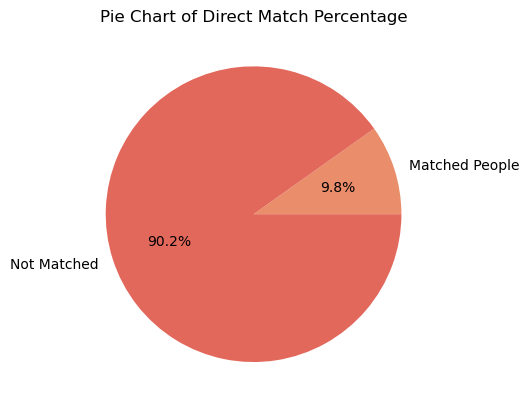

In [89]:
plt.pie(slices, labels=labels, autopct="%1.1f%%", colors=colors)
plt.title("Pie Chart of Direct Match Percentage")
plt.show()

In [90]:
slices = [father_match_percent, father_remaining_percent]
labels = ['Matched Father', 'Not Matched'] 

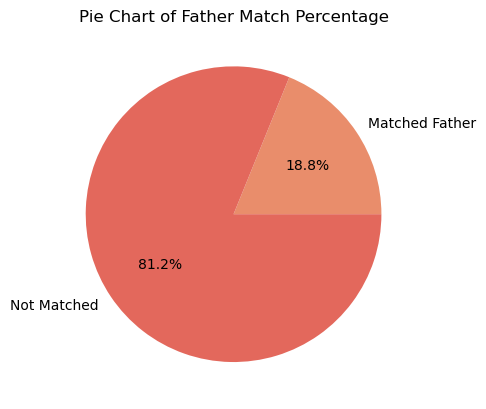

In [91]:
plt.pie(slices, labels=labels, autopct="%1.1f%%", colors=colors)
plt.title("Pie Chart of Father Match Percentage")
plt.show()

In [92]:
slices = [mother_match_percent, mother_remaining_percent]
labels = ['Matched Mother', 'Not Matched'] 

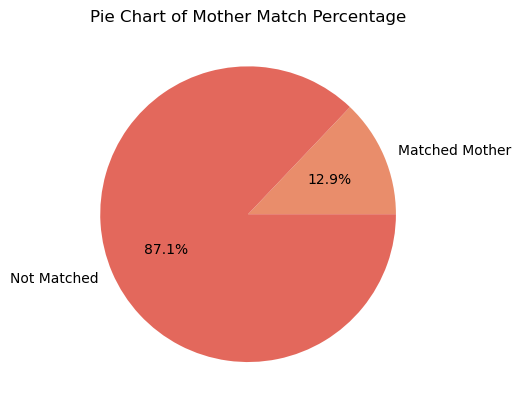

In [93]:
plt.pie(slices, labels=labels, autopct="%1.1f%%", colors=colors)
plt.title("Pie Chart of Mother Match Percentage")
plt.show()

In [94]:
baptisms_merged_direct_df.columns

Index(['#ID', 'DMission', 'MMission', 'FMission', 'Mission', 'DeathLinkBasis',
       'BurialDate', 'DeathNumber', 'SCOfficiant', 'Recorder', 'Officiant',
       'MNumber', 'MReligiousStatus', 'MEthnicity', 'MOrigin', 'MSurname',
       'MNativeName', 'MSpanishName', 'FMilitaryStatus', 'FReligiousStatus',
       'FEthnicity', 'FOrigin', 'FSurname', 'FNativeName', 'FSpanishName',
       'FNumber', 'BirthDate', 'DerivedOrigin', 'ReligiousStatus', 'Ethnicity',
       'Origin', 'Surname', 'NativeName', 'SpanishName', 'Age', 'Place',
       'TypePhrase', 'SupliCeremoniaDate', 'Number', 'Date', 'FmtdDate',
       'Type', 'MaritalStatus', 'Sex', 'Leg', 'Unit', 'Level', 'Notes'],
      dtype='object')

In [102]:
parent_father_df.columns

Index(['Current_Location', 'First', 'First_Normalized', 'Last',
       'Last_Normalized', 'Race', 'Rank', 'Gender', 'Origin', 'Age',
       'Spouse_First', 'Spouse_Last', 'Father_First', 'Father_Last',
       'Mother_First', 'Mother_Last', 'Child1', 'Child2', 'Child3', 'Child4',
       'Child5', 'Child6', 'Child7', 'Child8', 'Child9', 'Child10', 'Child11',
       'Child12', 'Child13', 'Child14', 'Origin Parish', 'Race in Other',
       'Location Other Race', 'Notes/URL', 'ecpp_id'],
      dtype='object')

<Axes: xlabel='Ethnicity', ylabel='Count'>

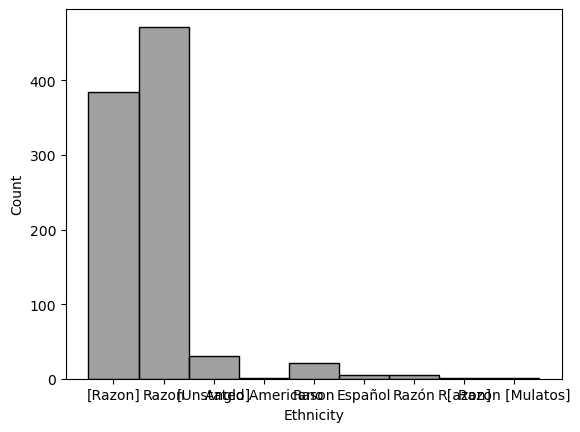

In [113]:
sns.histplot(data=baptisms_merged_father_df, x="Ethnicity", color='grey')

<Axes: xlabel='Ethnicity', ylabel='Count'>

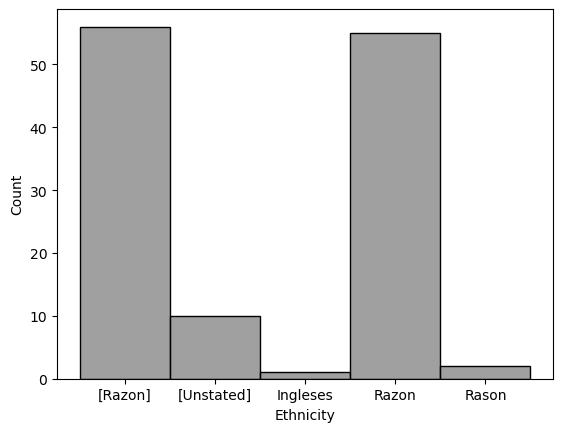

In [114]:
sns.histplot(data=baptisms_merged_direct_df, x="Ethnicity", color='grey')

In [108]:
parent_father_df['Race'] = parent_father_df['Race'].str.strip().str.replace(',', '').replace(' ', '').str.title()

/var/folders/11/8ksxnknx25vggx01_lhybb9c0000gn/T/ipykernel_82822/2586974856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parent_father_df['Race'] = parent_father_df['Race'].str.strip().str.replace(',', '').replace(' ', '').str.title()


<Axes: xlabel='Ethnicity', ylabel='Count'>

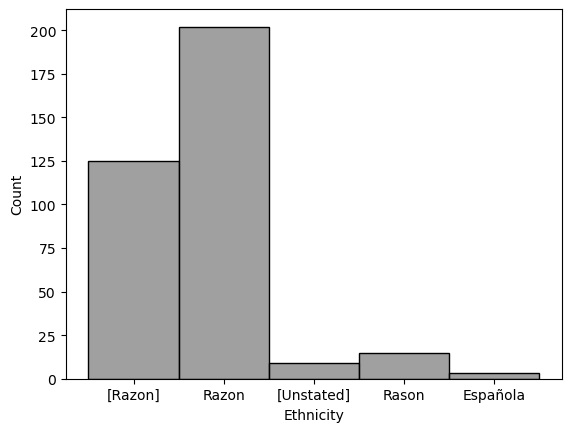

In [115]:
sns.histplot(data=baptisms_merged_mother_df, x="Ethnicity", color='grey')

<Axes: xlabel='Race', ylabel='Count'>

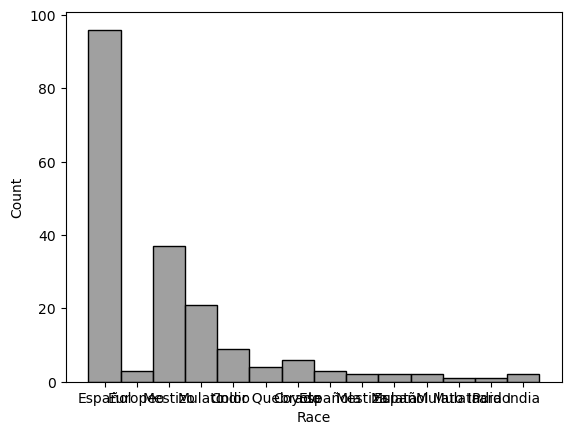

In [109]:
sns.histplot(data=parent_father_df, x="Race", color='grey')

In [110]:
parent_father_df.Race.value_counts()

Race
Español           96
Mestizo           37
Mulato            21
Indio              9
Coyote             6
Color Quebrado     4
Europeo            3
Española           3
Mestiza            2
Mulata             2
Español Mulata     2
India              2
Mulato India       1
Pardo              1
Name: count, dtype: int64

In [117]:
parent_mother_df.Race.value_counts()

Race
española           50
mestiza            23
mulata             22
india               7
coyota              7
mulato, india       3
, india             2
indio, india        2
español, india      2
indio,              2
español,            2
, española          1
orphan, unknown     1
coyote, india       1
español             1
parda               1
Name: count, dtype: int64

In [119]:
merged_direct_df.Race.value_counts()

Race
español            29
mestizo            14
española           13
mulato             10
español,            6
mestiza             4
mulata              4
español, india      3
español, mulata     3
, española          2
coyota              2
coyote              1
color quebrado      1
, mestiza           1
indio,              1
, india             1
, mulata            1
mulato, india       1
Name: count, dtype: int64